In [2]:
import math, datetime, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


def load_data(data_path):
  data = pd.read_csv(data_path)  
  return data

inbound = load_data("inbound_loads.csv")
outbound = load_data("outbound_laods.csv")
weather = load_data("weather.csv")
door_inbound = load_data("feature_train_inbound_door_open")
door_outbound = load_data("feature_train_outbound_door_open")

#For loop to ensure that all pallet data is in the same dataframe
pallet = load_data("Pallet_history_Gold_Spike[0].csv")
for x in range(1, 10):
    pallet = pd.concat([pallet, load_data(f"Pallet_history_Gold_Spike[{x}].csv")])
trainentest = load_data("demand_kWtrain_val.csv")
train = trainentest.iloc[:273988,:]
test = trainentest.iloc[273988:, :]

## Plan de campagne:

- Process the weather data into workable data for the algo
- Calculate on a minute-to-minute basis how many products are 'new' in the warehouse.
- Try to process the inbound and outbound data to make the amounts of incoming and outgoing products available
- Try to estimate on a minute-to-minute basis how many doors are open at any point in time.
    - This should be done on a percentage-based scale (how much percent of the minute was a door open)

In [3]:
# for data visualization
import math, datetime, time, random
import matplotlib.pyplot as plt
import missingno

### Concatting door open from inbound and outbound

In [4]:
door_outbound = door_outbound.rename(columns={"counts":"count"})
base_door = pd.concat([door_inbound, door_outbound['count']], axis=1)
base_door.set_index('datetime_local', inplace=True)
total = base_door['counts'] + base_door['count']  
base_door = base_door.assign(total=total)
base_door = base_door.drop(['counts', 'count'], axis=1)


In [23]:
base_df

,demand_kW,year,month,weekday,day,hour,minute,datetime,Relative Humidity,Temperature,datetime_UTC,hour,total
datetime_local,,,,,,,,,,,,,
2018-12-31 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 18:00:00-06:00,50.37,53.6,2019-01-01 00:00:00,18.0,NaN
2018-12-31 18:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 18:05:00-06:00,50.37,53.6,2019-01-01 00:05:00,18.0,NaN
2018-12-31 18:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 18:10:00-06:00,50.37,53.6,2019-01-01 00:10:00,18.0,NaN
2018-12-31 18:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 18:15:00-06:00,50.37,53.6,2019-01-01 00:15:00,18.0,NaN
2018-12-31 18:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 18:20:00-06:00,50.37,53.6,2019-01-01 00:20:00,18.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 17:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 17:35:00-06:00,82.89,68.0,2021-12-31 23:35:00,17.0,NaN
2021-12-31 17:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 17:40:00-06:00,82.89,68.0,2021-12-31 23:40:00,17.0,NaN
2021-12-31 17:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 17:45:00-06:00,82.89,68.0,2021-12-31 23:45:00,17.0,NaN


In [38]:
def addtimecol(df, colname): ####input df and colname 
    df[colname] = pd.to_datetime(df[colname])         
    df['year'] = df[colname].dt.year
    df['month'] = df[colname].dt.month
    df['weekday'] = df[colname].dt.weekday
    df['day'] = df[colname].dt.day
    df['hour'] = df[colname].dt.hour
    df['minute'] = df[colname].dt.minute        
    return df

#Create new dummy dfs
base_df = train.copy()
base_weather = weather.copy()
base_inbound_door = door_inbound.copy()
base_outbound_door = door_outbound.copy()

#Remove unnecessary columns
base_df = base_df.drop('Unnamed: 0', axis=1)
base_weather = base_weather.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
base_weather["localstrptime"]= pd.to_datetime(base_weather["localstrptime"])
base_df['datetime_local'] = pd.to_datetime(base_df['datetime_local'])
base_weather = base_weather.rename(columns={'localstrptime':'datetime_local'})
#base_weather['datetime_local'] = [datetime.datetime.strptime(x, 'yyyy/MM/dd HH:mm:SS') for x in base_weather['localstrptime']]

#Add time columns.
addtimecol(base_df, 'datetime_local')

#Set index to datetime
base_df.set_index('datetime_local', inplace=True)
base_weather.set_index('datetime_local', inplace=True)
base_door.set_index('datetime_local', inplace=True)

#Concatenate the weather DataFrame to the base DataFrame
base_df = pd.concat([base_df, base_weather], axis=1)
base_df = pd.concat([base_df, base_door], axis=1)


# Drop all NaN values\n"
base_df.dropna(subset=['demand_kW', 'Temperature'])

base_df

,demand_kW,year,month,weekday,day,hour,minute,datetime,Relative Humidity,Temperature,datetime_UTC,hour,level_0,index,total
datetime_local,,,,,,,,,,,,,,,
2018-12-31 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 18:00:00-06:00,50.37,53.6,2019-01-01 00:00:00,18.0,0,0,1.0
2018-12-31 18:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 18:05:00-06:00,50.37,53.6,2019-01-01 00:05:00,18.0,1,1,1.0
2018-12-31 18:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 18:10:00-06:00,50.37,53.6,2019-01-01 00:10:00,18.0,2,2,1.0
2018-12-31 18:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 18:15:00-06:00,50.37,53.6,2019-01-01 00:15:00,18.0,3,3,0.0
2018-12-31 18:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 18:20:00-06:00,50.37,53.6,2019-01-01 00:20:00,18.0,4,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 17:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 17:35:00-06:00,82.89,68.0,2021-12-31 23:35:00,17.0,485205,485205,0.0
2021-12-31 17:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 17:40:00-06:00,82.89,68.0,2021-12-31 23:40:00,17.0,485206,485206,0.0
2021-12-31 17:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 17:45:00-06:00,82.89,68.0,2021-12-31 23:45:00,17.0,485207,485207,0.0


In [37]:
#base_door = base_door.reset_index(level=[0])
base_door['datetime_local'] = pd.to_datetime(base_door['datetime_local'])
#base_door['datetime_local'] = pd.Series(test.datetime_local.dt.to_pydatetime(), dtype='O')
type(base_door['datetime_local'][0])


pandas._libs.tslibs.timestamps.Timestamp

In [33]:
base_df = base_df.reset_index(level=[0])
type(base_df['datetime_local'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [40]:
dummy_df = base_df.dropna(subset=['demand_kW', 'Temperature', 'Relative Humidity'])
dummy_df = dummy_df.reset_index()
dummy_df = dummy_df.drop(['hour'], axis=1)
dummy_df = dummy_df.drop(['datetime'], axis=1)
dummy_df = dummy_df.drop(['datetime_local'], axis=1)
dummy_df = dummy_df.drop(['datetime_UTC'], axis=1)
dummy_df


,demand_kW,year,month,weekday,day,minute,Relative Humidity,Temperature,level_0,index,total
0,2064.101392,2018.0,12.0,0.0,31.0,15.0,61.27,46.40,42,42,0.0
1,1874.002081,2018.0,12.0,0.0,31.0,30.0,61.27,46.40,45,45,0.0
2,1988.168511,2018.0,12.0,0.0,31.0,45.0,65.60,44.60,48,48,0.0
3,2022.795943,2018.0,12.0,0.0,31.0,0.0,65.60,44.60,52,52,0.0
4,1986.981872,2018.0,12.0,0.0,31.0,15.0,65.60,44.60,55,55,0.0
...,...,...,...,...,...,...,...,...,...,...,...
116228,2527.739000,2021.0,10.0,0.0,11.0,50.0,87.75,57.20,459913,459913,3.0
116229,2359.505000,2021.0,10.0,0.0,11.0,53.0,83.84,57.92,459916,459916,3.0
116230,2156.104000,2021.0,10.0,0.0,11.0,55.0,87.75,57.20,459918,459918,3.0
116231,2259.711000,2021.0,10.0,0.0,11.0,0.0,87.75,57.20,459923,459923,3.0


In [ ]:
dummy_df.to_csv

# Model Building

First we build the skeleton:
- Divide into train/test
- Set target column
- Get Accuracy

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


#Define train, test sets\n",
train, test = train_test_split(dummy_df)
X_train = train.copy().drop(['demand_kW'], axis=1)
Y_train = train['demand_kW']
X_test = test.copy().drop(['demand_kW'], axis=1)
Y_test = test['demand_kW']

## Support Vector Regression

In [42]:
svm = SVR()
svm.fit(X_train, Y_train)

SVR()

In [43]:
acc = svm.predict(X_test)
result = r2_score(list(Y_test), acc)
result

0.31812052803461155

In [73]:
mse_svr = mean_squared_error(list(Y_test), acc)
mae_svr = mean_absolute_error(list(Y_test), acc)

print("mse", mse_svr)
print("mae", mae_svr)

mse 308831.688756801
mae 455.0302952936833


## Random Forest

In [48]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 200)
rf.fit(X_train, Y_train)



RandomForestRegressor(n_estimators=200)

In [49]:
acc_rf = rf.predict(X_test)

result = r2_score(list(Y_test), acc_rf)
result

0.9471820046457805

Random Forest - 100 trees = 0.9464962000675328
Random Forest - 200 trees = 0.9471820046457805



In [58]:
mse = mean_squared_error(list(Y_test), acc_rf)
mae = mean_absolute_error(list(Y_test), acc_rf)

print("mse", mse)
print("mae", mae)

mse 460828.9917937321
mae 545.1102320699227


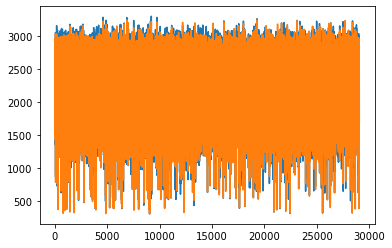

In [54]:
plt.plot(list(Y_test))
plt.plot(acc_rf)




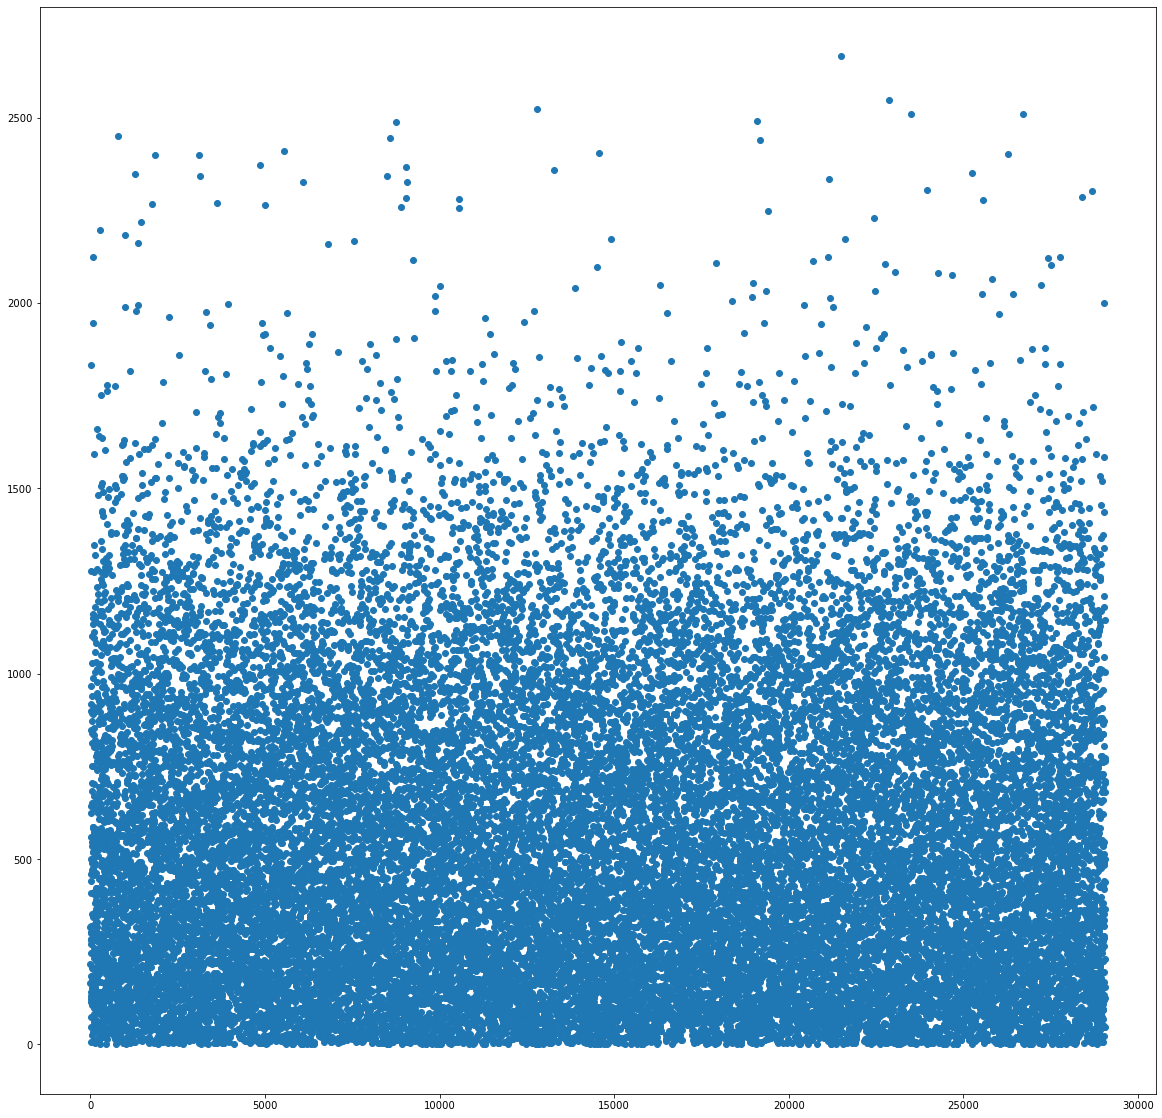

In [69]:
diff = abs(list(Y_test) - acc_rf)
diff

y_axis = range(0,len(Y_test))
y_axis

plt.figure(figsize=(20,20))

plt.scatter(y_axis,diff)
plt.show()



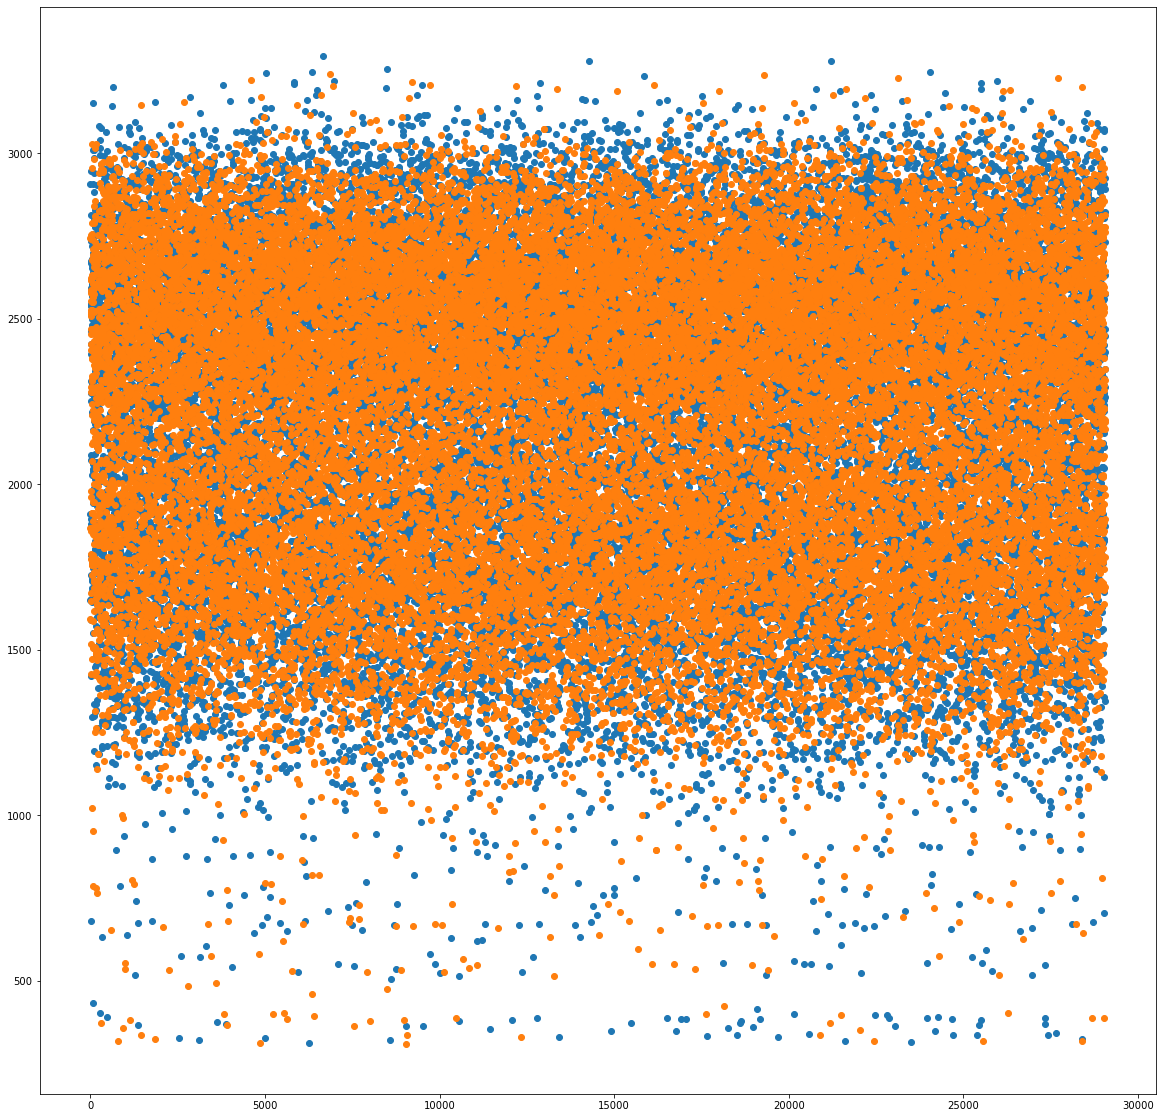

In [72]:
plt.figure(figsize=(20,20))

plt.scatter(y_axis,Y_test)
plt.scatter(y_axis,acc_rf)

plt.show()


In [63]:
Y_test

6877      1910.219774
16813     2907.993809
37731     1649.843242
32249     1879.090388
54430     2423.743949
             ...     
114894    2447.745000
45228     1873.730016
26020     2347.295493
90841     2892.611000
26507     2399.512697
Name: demand_kW, Length: 29059, dtype: float64